In [72]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image
from tqdm import tnrange, tqdm_notebook
from time import sleep
from random import shuffle

pd.options.mode.chained_assignment = None

%matplotlib inline

### Constants

In [73]:
DATASET_DIR = "./TytanicDisasterData/"
TRAIN_DATA_FILE = "train.csv"
TEST_DATA_FILE = "test.csv"

TRAIN_SAMPLES = 891
TEST_SAMPLES = 418

### Dataset info

- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain NaN)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin**: Cabin number of the passenger (Some entries contain NaN)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)


### Load data

In [74]:
df_train_raw = pd.read_csv(DATASET_DIR + TRAIN_DATA_FILE, engine="python")
df_test_raw = pd.read_csv(DATASET_DIR + TEST_DATA_FILE, engine="python")

I will merge the data to improve preprocessing and feature engineering process.

In [75]:
# Extracting survived data
df_survived = df_train_raw["Survived"].copy()
df_train_raw.drop("Survived", inplace=True, axis=1)

# Creating dataframe with combined data
df_combined = df_train_raw.append(df_test_raw)
df_combined.reset_index(inplace=True)
df_combined.drop("index", inplace=True, axis=1)

# Restoring extracted Survived parameter
df_train_raw["Survived"] = df_survived

### Analyze data

Checking num of samples and features

In [76]:
print("All Samples: {}".format(df_combined.shape[0]))
print("Train Samples: {}".format(df_train_raw.shape[0]))
print("Test Samples: {}".format(df_test_raw.shape[0]))
print("Features: {}".format(list(df_combined.columns)))

All Samples: 1309
Train Samples: 891
Test Samples: 418
Features: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [77]:
df_combined.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### PassengerId
I believe number of passenger had nothing to do with survival probability.

#### Pclass
If we assume that rooms of specific class was located in part of ship closer to boats then this parameter could had some connection with survival probability. Rich people could have more "power" to survive.

In [78]:
# Checking for NaN values in dataframe
assert df_combined["Pclass"].isnull().values.any() == False

In [79]:
print("Unique values of Pclass parameter: {}".format(set(df_combined["Pclass"].tolist())))

Unique values of Pclass parameter: {1, 2, 3}


In [80]:
df_pclass_survived = pd.concat([df_train_raw.loc[(df_train_raw["Pclass"] == 1)]["Survived"],
                                df_train_raw.loc[(df_train_raw["Pclass"] == 2)]["Survived"],
                                df_train_raw.loc[(df_train_raw["Pclass"] == 3)]["Survived"]],
                               axis=1, keys=["Class 1 Survival", "Class 2 Survival", "Class 3 Survival"])


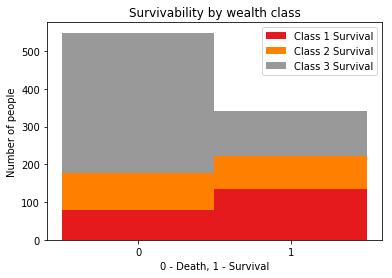

In [81]:
ax = df_pclass_survived[["Class 1 Survival", "Class 2 Survival", "Class 3 Survival"]].plot.hist(
         bins=np.arange(len(set(df_train_raw["Survived"].tolist())) + 1) - 0.5, 
         stacked=True, xticks=range(0, int(df_train_raw["Survived"].max() + 1)), 
         title="Survivability by wealth class", colormap="Set1")

ax.set_xlabel("0 - Death, 1 - Survival")
ax.set_ylabel("Number of people")

We can clearly see that the richer class the larger percent of whole group has survived.

#### Name


In [82]:
df_combined["Name"].head(20)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

Names should probably have some connection with survival probability - yet there is no information about those people in this dataset. It would need additional research on each persons history. 

But actually there might be another hint here. We have titles like "Master", "Mr", "Miss", "Don". We can get death ratio per class and average age of group.

In [83]:
df_combined["Title"] = df_combined["Name"].apply(
    lambda word: [w for w in word.split() if "." in w][0].replace(".", ""))

In [84]:
print("Unique values of Title parameter: {}".format(set(df_combined["Title"])))

Unique values of Title parameter: {'Mme', 'Lady', 'Mr', 'Dona', 'Sir', 'Col', 'Jonkheer', 'Miss', 'Mrs', 'Countess', 'Ms', 'Mlle', 'Capt', 'Rev', 'Dr', 'Major', 'Don', 'Master'}


I will calculate average Age per Title values:

In [85]:
df_title_age = df_combined.groupby("Title", as_index=False)["Age"].median()

In [86]:
df_title_age

,Title,Age
0,Capt,70.0
1,Col,54.5
2,Countess,33.0
3,Don,40.0
4,Dona,39.0
5,Dr,49.0
6,Jonkheer,38.0
7,Lady,48.0
8,Major,48.5
9,Master,4.0


In [87]:
title_age_map = dict()
for index, row in df_title_age.iterrows():
    title_age_map[row["Title"]] = row["Age"]

#### Sex 
Should have impact on survivability. Men body from biological perspective is stronger. Taking cultural aspect into consideraction gentelmen prioritized safety of women. Additionaly in history - whenever there was some disaster/war, children and women were protected first.

In [88]:
# Checking for NaN values in dataframe
assert df_combined["Sex"].isnull().values.any() == False

In [89]:
print("Unique values of Sex parameter: {}".format(set(df_combined["Sex"].tolist())))

Unique values of Sex parameter: {'male', 'female'}


In [90]:
df_sex_survived = pd.concat([df_train_raw.loc[(df_train_raw["Sex"] == "female")]["Survived"],
                             df_train_raw.loc[(df_train_raw["Sex"] == "male")]["Survived"]],
                            axis=1, keys=["Female", "Male"])

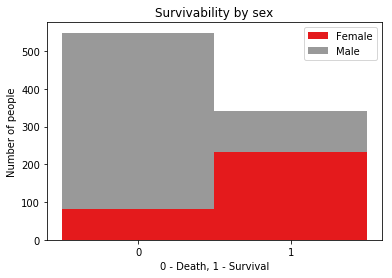

In [91]:
ax = df_sex_survived[["Female", "Male"]].plot.hist(
         bins=np.arange(len(set(df_train_raw["Survived"].tolist())) + 1) - 0.5, stacked=True, 
         xticks=range(0, int(df_train_raw["Survived"].max() + 1)), title="Survivability by sex", 
         colormap="Set1")

ax.set_xlabel("0 - Death, 1 - Survival")
ax.set_ylabel("Number of people")

It is very clear that majority of women survived and men died. Therefore we can assume that women were given priority during evacuation.

#### Age
Older people and children has less stamina, and power to push their way through or survive in running crowd. Age should be good parameter for predicting survival probability.

In [92]:
# Checking for NaN values in dataframe
# assert df_combined["Age"].isnull().values.any() == False

There are null values in "Age" column. Perfoming dataset cleaning.

In [93]:
print("Number of Nan values in Age column: {}".format(df_combined["Age"].isnull().sum()))

Number of Nan values in Age column: 263


I will refill Age values with data retrieved from Title analysis.

In [94]:
# Refilling values in combined data
for index, row in df_combined.iterrows():
    if np.isnan(row["Age"]):
        df_combined.set_value(index, "Age", title_age_map[row["Title"]])

# Refilling values in train data for visualisation purposes
df_train_raw["Age"] = df_combined["Age"].iloc[:TRAIN_SAMPLES]
        
print("Number of Nan values in Age column: {}".format(df_combined["Age"].isnull().sum()))

Number of Nan values in Age column: 0


In [95]:
df_age_survived = pd.concat([df_train_raw.loc[(df_train_raw["Survived"] == 0)]["Age"],
                             df_train_raw.loc[(df_train_raw["Survived"] == 1)]["Age"]],
                            axis=1, keys=["Died", "Survived"])

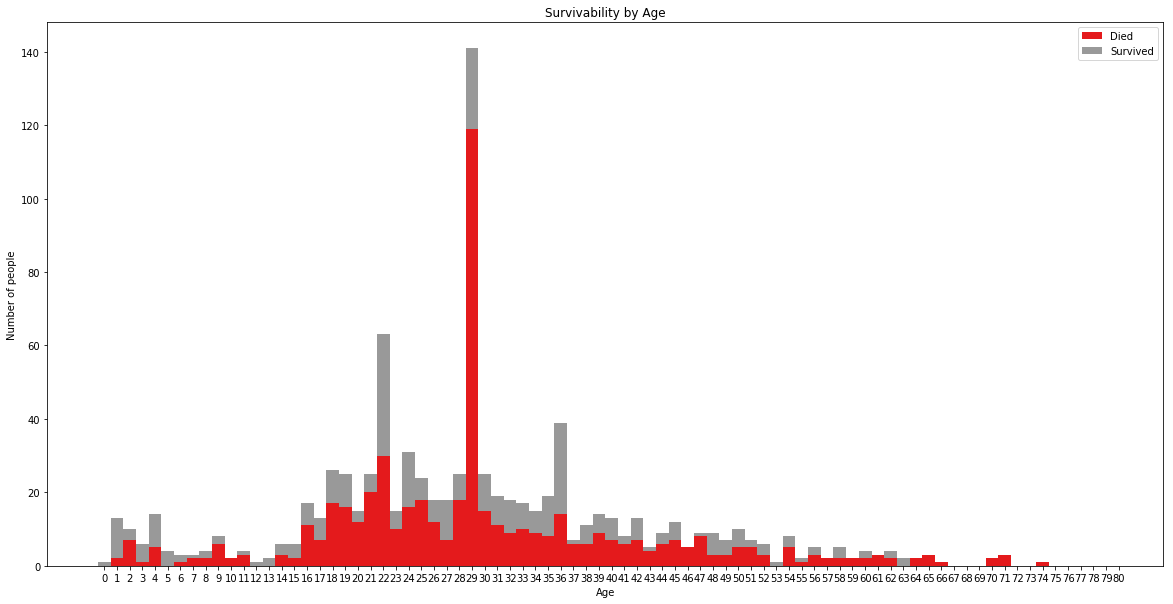

In [96]:
ax = df_age_survived[["Died", "Survived"]].plot.hist(
         bins=np.arange(int(df_train_raw["Age"].max()) + 1) - 0.5, stacked=True, 
         xticks=range(0, int(df_train_raw["Age"].max()) + 1), title="Survivability by Age", colormap="Set1",
         figsize=(20,10))

ax.set_xlabel("Age")
ax.set_ylabel("Number of people")

In [97]:
deaths_in_percents_per_age = list()
age_list = list(range(0, int(df_train_raw["Age"].max()), 10))
for i, age in enumerate(age_list):
    if i == len(age_list) - 1:
        deaths_per_age = df_age_survived.loc[(df_age_survived["Died"] >= age_list[i])].shape[0]
        people_num_per_age = df_train_raw.loc[(df_train_raw["Age"] >= age_list[i])].shape[0]
    else:
        deaths_per_age = df_age_survived.loc[(df_age_survived["Died"] >= age_list[i]) 
                                            & (df_age_survived["Died"] < age_list[i+1])].shape[0]
        people_num_per_age = df_train_raw.loc[(df_train_raw["Age"] >= age_list[i])
                                              & (df_train_raw["Age"] < age_list[i+1])].shape[0]
    
    if people_num_per_age > 0:
        percent = deaths_per_age * 100 / people_num_per_age
    else:
        percent = 0

    deaths_in_percents_per_age.append(percent)

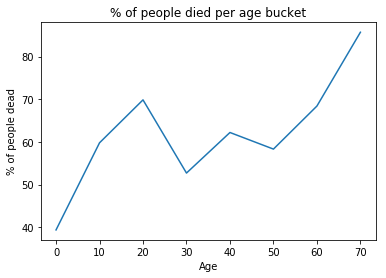

In [98]:
plt.plot(age_list, deaths_in_percents_per_age)
plt.title("% of people died per age bucket")
plt.xlabel("Age")
plt.ylabel("% of people dead")

According to following graphs, we can say that death rate is much lower for people below 20 and much higher for people after 50 years old. 

#### SibSp - number of siblings and spouses

I have no idea if this could have connection or not. Maybe if someone was in larger group then they helped each other rather than fighting to survive.

In [99]:
# Checking for NaN values in dataframe
assert df_combined["SibSp"].isnull().values.any() == False

In [100]:
print("SibSp values: {}".format(set(df_combined["SibSp"].tolist())))

SibSp values: {0, 1, 2, 3, 4, 5, 8}


In [101]:
df_sibsp_survived = pd.concat([df_train_raw.loc[(df_train_raw["Survived"] == 0)]["SibSp"],
                               df_train_raw.loc[(df_train_raw["Survived"] == 1)]["SibSp"]],
                              axis=1, keys=["Died", "Survived"])

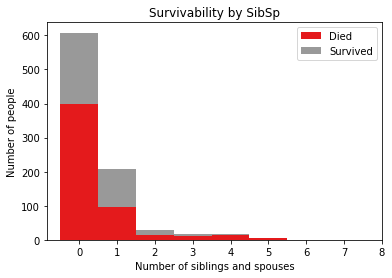

In [102]:
ax = df_sibsp_survived[["Died", "Survived"]].plot.hist(
         bins=np.arange(len(set(df_train_raw["SibSp"].tolist())) + 1) - 0.5, stacked=True, 
         xticks=range(0, int(df_train_raw["SibSp"].max() + 1)), title="Survivability by SibSp", colormap="Set1")

ax.set_xlabel("Number of siblings and spouses")
ax.set_ylabel("Number of people")

People with less siblings/spouses has smaller death ratio than those in larger families. 

#### Parch
Maybe someone wanted rather their children to be saved or parents rather than himself.

In [103]:
# Checking for NaN values in dataframe
assert df_combined["Parch"].isnull().values.any() == False

In [104]:
df_parch_survived = pd.concat([df_train_raw.loc[(df_train_raw["Survived"] == 0)]["Parch"],
                               df_train_raw.loc[(df_train_raw["Survived"] == 1)]["Parch"]],
                              axis=1, keys=["Died", "Survived"])

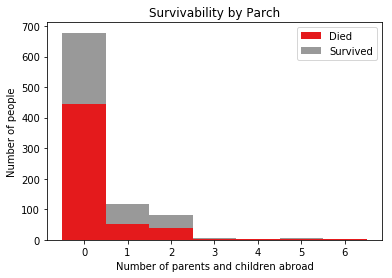

In [105]:
ax = df_parch_survived[["Died", "Survived"]].plot.hist(
         bins=np.arange(len(set(df_train_raw["Parch"].tolist())) + 1) - 0.5, stacked=True, 
         xticks=range(0, int(df_train_raw["Parch"].max() + 1)), title="Survivability by Parch", colormap="Set1")

ax.set_xlabel("Number of parents and children abroad")
ax.set_ylabel("Number of people")

Again the larger group of pepople the smaller survivability ratio.

#### Companion

Actually SibSp and Parch can be reduced to single parameter which says if someone was alone or not. Someone without parents/children/sibling/spouses was simply alone. And we can see in both parameters Parch and SibSp that the larger group of connected people the higher chance of death.

In [106]:
df_combined["Companion"] = df_combined["Parch"] + df_combined["SibSp"]

#### Family Size

It is also possible to higlight some info about family size. Those with family size larger than 3 has much higher death ratio.

In [107]:
df_combined["SmallFamily"] = df_combined["Companion"].apply(lambda x: 1 if 1 <= x <= 2 else 0)
df_combined["LargeFamily"] = df_combined["Companion"].apply(lambda x: 1 if 3 <= x else 0)

#### Alone

Another parameter possible to be engineered.

In [108]:
df_combined["Alone"] = df_combined["Companion"].apply(lambda x: 1 if x == 0 else 0)

#### Ticket & Fare
There are only ticket names and prices. It won't probably be any use - but I wonder if staff of Titanic had any special ticket names or fares. There might be possibility that hey had to enter boats as last - because they help with saving people and that lead to their death.

In [109]:
# Checking for NaN values in dataframe
assert df_combined["Ticket"].isnull().values.any() == False
# assert df_combined["Fare"].isnull().values.any() == False

Data has "Nan" values in "Fare" field. Replacing with mean.

In [110]:
print("Number of Nan values in Fare column: {}".format(df_combined["Fare"].isnull().sum()))

Number of Nan values in Fare column: 1


In [111]:
df_combined["Fare"].fillna(df_combined["Fare"].mean(), inplace=True)

print("Number of Nan values in Fare column: {}".format(df_combined["Fare"].isnull().sum()))

Number of Nan values in Fare column: 0


In [112]:
print("Ticket values: {}".format(set(df_combined["Ticket"].tolist())))

Ticket values: {'STON/O 2. 3101289', 'A/5 2466', 'W./C. 6609', '349231', '2678', 'SOTON/O.Q. 3101306', '33638', '2628', 'PC 17755', 'PC 17760', '240261', 'A/5 21173', '236854', 'SOTON/O.Q. 3101305', 'PC 17603', '371060', '2674', '334915', '110564', 'PC 17596', '237393', 'W./C. 6608', '4134', '347089', 'A/5 2817', 'C.A. 37671', 'A/5. 851', '368702', '244252', 'C.A. 18723', '345773', '248734', 'PC 17607', '11753', '17474', '111320', '347090', 'S.W./PP 752', '31418', '334912', 'C.A. 34260', '350408', '113791', 'SC/PARIS 2159', '244360', '345764', '5727', 'W./C. 6607', '112053', '2692', 'SC/AH 3085', '2641', '364498', '236171', '315092', '343120', '28664', '2683', '250649', '31027', '2689', 'SC/PARIS 2166', '382649', '11765', 'SOTON/OQ 3101317', '312991', '349212', 'A.5. 11206', 'SOTON/O.Q. 392078', 'STON/O 2. 3101268', '7935', '330932', '237216', '19928', '350404', '364516', 'SC/PARIS 2167', '248747', '110152', '349222', '236853', '29750', '2223', '350060', '2665', '31028', 'PP 9549', 'SC

In [113]:
print("Ticket values: {}".format(sorted(set(df_combined["Fare"].tolist()))))

Ticket values: [0.0, 3.1708, 4.0125, 5.0, 6.2375, 6.4375, 6.45, 6.4958, 6.75, 6.8583, 6.95, 6.975, 7.0, 7.0458, 7.05, 7.0542, 7.125, 7.1417, 7.225, 7.2292, 7.25, 7.2833, 7.3125, 7.4958, 7.5208, 7.55, 7.575, 7.5792, 7.6292, 7.65, 7.7208, 7.725, 7.7292, 7.7333, 7.7375, 7.7417, 7.75, 7.775, 7.7792, 7.7875, 7.7958, 7.8, 7.8208, 7.8292, 7.85, 7.8542, 7.875, 7.8792, 7.8875, 7.8958, 7.925, 8.0292, 8.05, 8.1125, 8.1375, 8.1583, 8.3, 8.3625, 8.4042, 8.4333, 8.4583, 8.5167, 8.6542, 8.6625, 8.6833, 8.7125, 8.85, 8.9625, 9.0, 9.2167, 9.225, 9.325, 9.35, 9.475, 9.4833, 9.5, 9.5875, 9.6875, 9.825, 9.8375, 9.8417, 9.8458, 10.1708, 10.4625, 10.5, 10.5167, 10.7083, 11.1333, 11.2417, 11.5, 12.0, 12.1833, 12.275, 12.2875, 12.35, 12.475, 12.525, 12.65, 12.7375, 12.875, 13.0, 13.4167, 13.5, 13.775, 13.7917, 13.8583, 13.8625, 13.9, 14.0, 14.1083, 14.4, 14.4542, 14.4583, 14.5, 15.0, 15.0333, 15.0458, 15.05, 15.1, 15.2458, 15.5, 15.55, 15.5792, 15.7417, 15.75, 15.85, 15.9, 16.0, 16.1, 16.7, 17.4, 17.8, 18.0, 

In [114]:
df_fare_survived = pd.concat([df_train_raw.loc[(df_train_raw["Survived"] == 0)]["Fare"],
                               df_train_raw.loc[(df_train_raw["Survived"] == 1)]["Fare"]],
                              axis=1, keys=["Died", "Survived"])

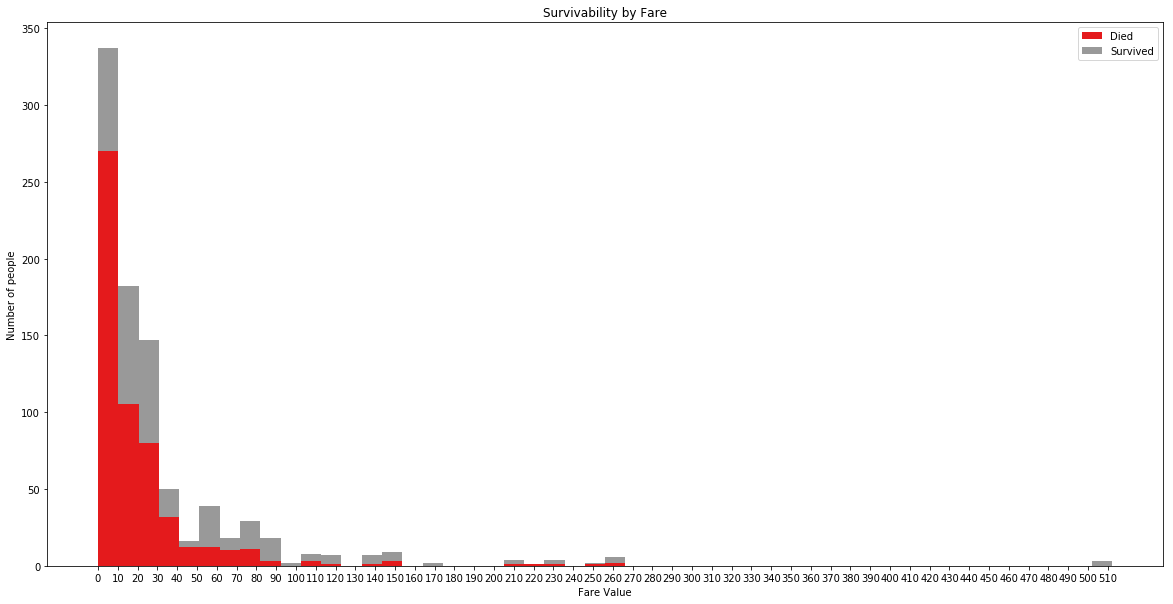

In [115]:
ax = df_fare_survived[["Died", "Survived"]].plot.hist(
         bins=50, stacked=True, title="Survivability by Fare", colormap="Set1", figsize=(20,10),
         xticks=range(0, int(df_train_raw["Fare"].max()), round(int(df_train_raw["Fare"].max())/50)))

ax.set_xlabel("Fare Value")
ax.set_ylabel("Number of people")

We can see that highest number of deaths can be observed for cheaper tickets.

#### Cabin

We could say that people from cabins closer to rescue boats have higher probability to be saved.

In [116]:
# Checking for NaN values in dataframe
# assert df_combined["Cabin"].isnull().values.any() == False

There are NaN values in "Cabin" column.

In [117]:
print("Number of Nan values in Cabin column: {}".format(df_combined["Cabin"].isnull().sum()))

Number of Nan values in Cabin column: 1014


In [118]:
print("Unique values of Cabin: {}".format(set(df_combined["Cabin"].values)))

Unique values of Cabin: {nan, 'B49', 'D36', 'D11', 'A18', 'E36', 'B26', 'F4', 'C110', 'D17', 'B41', 'B42', 'B57 B59 B63 B66', 'B58 B60', 'D20', 'C78', 'C128', 'C99', 'D45', 'F2', 'C54', 'C148', 'A32', 'C82', 'E63', 'A16', 'B30', 'E46', 'B4', 'D', 'B22', 'F G73', 'C50', 'C46', 'E24', 'D21', 'A11', 'A31', 'E10', 'B35', 'C68', 'A10', 'A9', 'B3', 'C80', 'A20', 'C132', 'F E57', 'B24', 'B86', 'B80', 'C53', 'E58', 'E52', 'C130', 'E40', 'B39', 'F E69', 'B11', 'E121', 'B71', 'E25', 'E33', 'C49', 'E101', 'E45', 'C55 C57', 'D33', 'A5', 'C124', 'C31', 'B38', 'C28', 'D26', 'D56', 'D37', 'C22 C26', 'E38', 'C23 C25 C27', 'C70', 'D47', 'F E46', 'E44', 'B5', 'A19', 'D50', 'B101', 'C87', 'C125', 'B79', 'D7', 'E67', 'C52', 'C111', 'C95', 'C105', 'C93', 'D46', 'B102', 'B50', 'F', 'E17', 'C97', 'B94', 'D6', 'D48', 'B61', 'A7', 'D9', 'C45', 'E34', 'D35', 'C91', 'D43', 'D49', 'E60', 'D40', 'B10', 'C104', 'B96 B98', 'B20', 'C6', 'D30', 'D28', 'C51', 'C90', 'C39', 'B82 B84', 'C47', 'C106', 'A34', 'C2', 'A23', 

We will leave first letter of Cabin as type and repleace all Nan values with "U" which means unknown.

In [119]:
df_combined["Cabin"].fillna("U", inplace=True)
print("Number of Nan values in Cabin column: {}".format(df_combined["Cabin"].isnull().sum()))

Number of Nan values in Cabin column: 0


In [120]:
df_combined["Cabin"] = df_combined["Cabin"].apply(lambda x: x[0])
print("Unique values of Cabin: {}".format(set(df_combined["Cabin"].values)))

Unique values of Cabin: {'C', 'T', 'U', 'G', 'D', 'B', 'E', 'F', 'A'}


#### Embarked

In [121]:
# Checking for NaN values in dataframe
# assert df_combined["Embarked"].isnull().values.any() == False

In [122]:
print("Number of Nan values in Embarked column: {}".format(df_combined["Embarked"].isnull().sum()))

Number of Nan values in Embarked column: 2


In [123]:
df_combined["Embarked"].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

Fill embarked values by most recent appearing embarkment

In [124]:
df_combined["Embarked"].fillna("S", inplace=True)
print("Number of Nan values in Embarked column: {}".format(df_combined["Embarked"].isnull().sum()))

Number of Nan values in Embarked column: 0


In [125]:
df_embarked_survived = pd.concat([df_train_raw.loc[(df_train_raw["Embarked"] == "C")]["Survived"],
                                  df_train_raw.loc[(df_train_raw["Embarked"] == "S")]["Survived"],
                                  df_train_raw.loc[(df_train_raw["Embarked"] == "Q")]["Survived"]],
                                 axis=1, keys=["C", "S", "Q"])

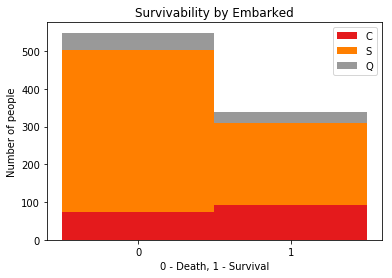

In [126]:
ax = df_embarked_survived[["C", "S", "Q"]].plot.hist(
         bins=np.arange(len(set(df_train_raw["Survived"].tolist())) + 1) - 0.5, stacked=True, 
         xticks=range(0, int(df_train_raw["Survived"].max() + 1)), title="Survivability by Embarked", 
         colormap="Set1")

ax.set_xlabel("0 - Death, 1 - Survival")
ax.set_ylabel("Number of people")

Death ratio between people that embarked at Queenstown and Southampton is almost the same. We can see that ratio is a little bit different for those that embarked at Cherbourg - more of them survived. Difference is quite unclear though.

#### Choosing parameters


Parameters to use:
- Sex
- Age
- Pclass
- SibSp
- Parch
- Fare
- Companion 
- Alone
- SmallFamily
- LargeFamily
- Title
- Embarked
- Cabin

Parameters to ignore:
- Ticket
- Name

I will try combination of all parameters.

In [127]:
df_combined = df_combined.drop(["Name", "Ticket"], axis=1)

### Processing data for input

In [128]:
features_for_one_hot_encode = ["Pclass", "Embarked", "Sex", "Title", "Cabin"]

for feature in features_for_one_hot_encode:
    df_combined = pd.concat([df_combined, pd.get_dummies(df_combined[feature])], axis=1)
    df_combined.drop(feature, axis=1, inplace=True)

In [129]:
features_for_normalization = ["Age", "Fare", "Companion", "Parch", "SibSp"]

normalized_features = dict()
for feature in features_for_normalization:
    mean, std = df_combined[feature].mean(), df_combined[feature].std()
    normalized_features[feature] = [mean, std]
    df_combined.loc[:, feature] = (df_combined[feature] - mean) / std

In [130]:
df_input = df_combined.iloc[:TRAIN_SAMPLES]
df_input.drop("PassengerId", axis=1, inplace=True)

df_labels = df_survived

df_test = df_combined.iloc[TRAIN_SAMPLES:]
df_test.drop("PassengerId", axis=1, inplace=True)

In [131]:
print("Input shape: {}".format(df_input.shape))
print("Test shape: {}".format(df_test.shape))

Input shape: (891, 43)
Test shape: (418, 43)


In [132]:
def cross_validation(samples, labels, val_ratio=0.15, randomize=False):
    """Divides inserted samples into train and validation sets."""
    assert len(samples) == len(labels)
    
    # Groups samples and labels
    sample_labels_stacked = list()
    for sample, label in zip(samples, labels):
        sample_labels_stacked.append((sample, label))
        
    if randomize:
        # Randomize order
        shuffle(sample_labels_stacked)
    
    # Divide samples
    split_index = round(len(sample_labels_stacked) * val_ratio)
    train_set = sample_labels_stacked[split_index:]
    val_set = sample_labels_stacked[:split_index]
    
    # Unwrap samples
    train_samples, train_labels = list(), list()
    for data in train_set:
        sample, label = data
        train_samples.append(sample)
        train_labels.append(label)
        
    val_samples, val_labels = list(), list()
    for data in val_set:
        sample, label = data
        val_samples.append(sample)
        val_labels.append(label)
    
    # Convert to ndarray
    train_samples = np.array(train_samples)
    train_labels = np.array(train_labels)
    val_samples = np.array(val_samples)
    val_labels = np.array(val_labels)
    
    return train_samples, train_labels, val_samples, val_labels

### Logistic Regression - Raw Implementation

In [133]:
class LogisticRegression:
    """Logistic Regression model.
    
    Arguments:
    ---------
    iterations: int
        Number of Gradient Descent Steps that will be performed in order to change weights of
        linear model
    learning_rate: float
        Weight applied for Gradient Descent Step during updating weights. (default: 0.001)
    verbose: boolean
        Flag for debugging. If set to true then error values achieved by model during training
        cycle will be displayed.
    """
    def __init__(self, iterations, learning_rate=0.001, verbose=False):
        self.w = None
      
        self.error_history = list()
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.verbose = verbose
    
    def fit(self, X, y):
        """Function that is adjusting Logistic Regression Model weights 'w' to inserted data 'X'
        according to target values 'y'."""
        
        # Ensure data is float type
        X = X.astype(np.float32)
        y = y.astype(np.float32)

        # Insert 1 values in first row of data for bias
        X = np.insert(X, 0, 1, axis=1)
        
        # Number of samples
        num_samples, num_features = X.shape
        
        # Xavier initialization for weights
        xavier_range = 1 / np.sqrt(num_features)
        self.w = np.random.uniform(-xavier_range, xavier_range, (num_features,))
        
        # Perform training
        for i in range(0, self.iterations):
            
            # Using weights for prediction
            pred = self._sigmoid(np.dot(X, self.w))
            
            # Gradient step - Calculating gradient
            gradient = (1 / num_samples) * (np.dot(X.T, (pred - y)))
                                       
            # Gradient step - Updating weights
            self.w = self.w - self.learning_rate * gradient
                                       
            # Calculating Cross-Entropy Error for new weights
            error = self._cross_entropy(X, y, num_samples)
            self.error_history.append(error)
                                       
            # Displaying learning progress every 100 iterations
            if self.verbose and i % 100 == 0:
                print("Iteration no. " + str(i) + ", error: " + str(error))
                
    def _sigmoid(self, X):
        """Application of Sigmoid function which squashes input values in range 0-1 which
        which corresponds to probability value ragne."""
        
        return 1 / (1 + np.exp(-X))
            
    def _cross_entropy(self, X, y, num_samples):
        """Implementation of Cross-Entropy - cost function for monitoring how classification
        is performed with current 'w' values"""
        
        pred = self._sigmoid(np.dot(X, self.w))
        return (-1 / num_samples) * np.sum(y * np.log10(pred) + (1 - y) * np.log10(1 - pred))
    
    def predict(self, X):
        """Function that takes feature values 'X' and returns predictions with usage of 
        current 'w' values"""
        
        # Ensure data is float type
        X = X.astype(np.float32)
        
        # Insert 1 values in first row of data for bias
        X = np.insert(X, 0, 1, axis=1)
        pred = self._sigmoid(np.dot(X, self.w))
        return pred

### Using model for prediction

In [134]:
def accuracy(predictions, expected_values):
    """Returning percentage value based on how many predictions match expected values."""
    return np.sum(np.round(predictions) == expected_values) / predictions.shape[0]

In [135]:
def r2_score(predictions, expected_values):
    """Model evaluation parameter - R2 score. Best possible score is 1.0 and it can be negative 
    (because the model can be arbitrarily worse)"""
    mean_y = np.mean(expected_values)
    ss_tot = sum((expected_values - mean_y) ** 2)
    ss_res = sum((expected_values - predictions) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

#### Training Various models

In [136]:
iteration_values = [1000, 1500, 2000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]

learning_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 
                  0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 
                  0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]

model_results = list()

for i in tnrange(len(iteration_values), desc="Iteration grid"):
    iterations = iteration_values[i]
    for j in tqdm_notebook(range(len(learning_rates)), desc="Learning Rate grid"):
        learning_rate = learning_rates[j]
        
        # Provide input data
        samples = df_input.as_matrix()
        labels = df_labels.as_matrix()

        # Divide into train, validation sets
        train_samples, train_labels, val_samples, val_labels = cross_validation(samples, labels)

        # Create model
        model = LogisticRegression(iterations, learning_rate=learning_rate)

        # Train on train data
        model.fit(train_samples, train_labels)

        # Predictions
        train_predictions = model.predict(train_samples)
        val_predictions = model.predict(val_samples)

        # Accuracy
        train_acc = accuracy(train_predictions, train_labels)
        val_acc = accuracy(val_predictions, val_labels)

        # R2 Score - model performance
        r2_score_value = r2_score(val_predictions, val_labels)

        model_results.append({"model": model, "train_acc": round(train_acc, 6), 
                              "val_acc": round(val_acc, 6), "r2_score": round(r2_score_value, 4),
                              "lr": learning_rate, "iter": iterations})

Display all results

In [137]:
model_results_sorted = sorted(model_results, key=lambda result: result["r2_score"], reverse=True) 
for i, result in enumerate(model_results_sorted):
    print("{}: | t_acc: {} | v_acc: {} | r2_score: {} | lr: {} | i: {}"
          .format(i, result["train_acc"], result["val_acc"], result["r2_score"],
                  result["lr"], result["iter"], "  " + " "*len(str(i))))

0: | t_acc: 0.828269 | v_acc: 0.813433 | r2_score: 0.3587 | lr: 0.03 | i: 1500
1: | t_acc: 0.82959 | v_acc: 0.813433 | r2_score: 0.358 | lr: 0.004 | i: 10000
2: | t_acc: 0.824306 | v_acc: 0.798507 | r2_score: 0.3571 | lr: 0.002 | i: 10000
3: | t_acc: 0.826948 | v_acc: 0.798507 | r2_score: 0.3568 | lr: 0.02 | i: 1000
4: | t_acc: 0.82959 | v_acc: 0.813433 | r2_score: 0.3566 | lr: 0.006 | i: 5000
5: | t_acc: 0.828269 | v_acc: 0.798507 | r2_score: 0.3559 | lr: 0.004 | i: 7500
6: | t_acc: 0.826948 | v_acc: 0.798507 | r2_score: 0.3556 | lr: 0.005 | i: 5000
7: | t_acc: 0.825627 | v_acc: 0.798507 | r2_score: 0.3554 | lr: 0.01 | i: 2000
8: | t_acc: 0.82959 | v_acc: 0.813433 | r2_score: 0.355 | lr: 0.005 | i: 7500
9: | t_acc: 0.832232 | v_acc: 0.813433 | r2_score: 0.3539 | lr: 0.04 | i: 1000
10: | t_acc: 0.825627 | v_acc: 0.798507 | r2_score: 0.3533 | lr: 0.001 | i: 17500
11: | t_acc: 0.833554 | v_acc: 0.798507 | r2_score: 0.3531 | lr: 0.05 | i: 1500
12: | t_acc: 0.825627 | v_acc: 0.798507 | r2_

#### Picking model

In [138]:
MODEL_INDEX = 0

In [139]:
model = model_results_sorted[MODEL_INDEX]["model"]

#### Prediction on train data

In [140]:
test_predictions = model.predict(df_test.as_matrix())
test_predictions = np.round(test_predictions)

In [141]:
result_dataframe = df_test_raw[["PassengerId"]]
result_dataframe["Survived"] = list(map(int, test_predictions.tolist()))

In [142]:
result_dataframe.to_csv("results.csv", index=False)

#### Kaggle score

![title](img/kaggle_score.png)

#### Possible improvements:
- I am using my self-coded LogisticRegression model. If I really wanted better results maybe I should do everything with sklearn algorithms - not manually. 
- Models like DecisionTrees, SVM, Gradient Boosting might have better results.
- Adding regularization to model.
- Maybe more feature engineering.
- Maybe better filling of missing data.
- Picking only necessary features for model - not all of them.
- Using real GridSearch rather than for loop with hardcoded values.